In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
import pickle
import ast

from glob import glob
from PIL import Image
from tqdm import tqdm

TensorFlow 2.x selected.


In [0]:
# Configuration
SEP = " -<>- "
IMG_SIZE = 299
MAX_LENGTH = 9

PATH = os.path.abspath('.') + "/drive/My Drive/data/train"
IMG_PATH = PATH + "/plots/"
BARS_PATH = PATH + "/train_barbbox.idl"
IMGSIZE_PATH = PATH + "/train_imgsize.idl"

START_TOKEN = [1.0, 1.0, 0.0]
END_TOKEN = [0.0, 0.0, 0.0]

In [0]:
# utilities

def get_normalized_data(bbox, real_imgsize):
    '''
    return bar's center coordinate and height
    '''
    imgsize, bar_direction = real_imgsize
    # top-left and bottom-right x coordinates divided by image width
    bbox[0] /= imgsize[0]
    bbox[2] /= imgsize[0]
    # top-left and bottom-right y coordinates divided by image height
    bbox[1] /= imgsize[1]
    bbox[3] /= imgsize[1]
    # normalized height
    if bar_direction == "vertical":
        height = abs(bbox[3] - bbox[1])
        result = [bbox[3], bbox[1], height]
    else:
        height = abs(bbox[2] - bbox[0])
        result = [bbox[2], bbox[0], height]

    return result

def load_image(image_path):
    img = tf.io.read_file(image_path)
    # decode_jpeg also works for png
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.xception.preprocess_input(img)
    return img, image_path

In [0]:
all_bars = []
all_img_name_vector = []

with open(BARS_PATH, "r") as fbar, open(IMGSIZE_PATH, "r") as fsize:
    for bars, imgsize in tqdm(zip(fbar, fsize)):
        bars = bars.strip()
        imgsize = imgsize.strip()
        bars = bars.split(SEP)
        imgsize = imgsize.split(SEP)
        assert bars[0] == imgsize[0], "image name not match!"
        
        all_img_name_vector.append(IMG_PATH + bars[0])
        boxs = ast.literal_eval(bars[1])
        imgsize = ast.literal_eval(imgsize[1])
        one_img_bar = [START_TOKEN] # start-token
        for box in boxs:
            bbox = box["bbox"]
            bar_info = get_normalized_data(bbox, imgsize)
            one_img_bar.append(bar_info)
        one_img_bar.append(END_TOKEN) # end-token
        
        # padding the sequence
        if len(one_img_bar) < MAX_LENGTH + 2:
            need = MAX_LENGTH + 2 - len(one_img_bar)
            for i in range(need):
                one_img_bar.append(END_TOKEN)
        
        all_bars.append(one_img_bar)

bars_vector, img_name_vector = shuffle(all_bars, all_img_name_vector, random_state=1)

30000it [00:05, 5050.87it/s]


In [0]:
# *** unit test section ***
len(bars_vector), len(img_name_vector)
print(bars_vector[55])
print(img_name_vector[55])

[[1.0, 1.0, 0.0], [0.5738636363636364, 0.125, 0.44886363636363635], [0.26325757575757575, 0.125, 0.13825757575757575], [0.22727272727272727, 0.125, 0.10227272727272727], [0.6041666666666666, 0.125, 0.47916666666666663], [0.5208333333333334, 0.125, 0.39583333333333337], [0.8314393939393939, 0.125, 0.7064393939393939], [0.9090909090909091, 0.125, 0.7840909090909091], [0.22727272727272727, 0.125, 0.10227272727272727], [0.7651515151515151, 0.125, 0.6401515151515151], [0.0, 0.0, 0.0]]
/content/drive/My Drive/data/train/plots/train_1296.jpg


In [0]:
max_length = MAX_LENGTH + 2
# Create training and validation sets
img_name_train, img_name_val, bar_train, bar_val = train_test_split(img_name_vector, bars_vector, test_size=0.04, random_state=0)

In [0]:
len(img_name_train), len(bar_train), len(img_name_val), len(bar_val)

(28800, 28800, 1200, 1200)

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
barinfo_size = 3
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [0]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor, _ = load_image(img_name)
    return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, bar_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.float32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    #print("feature:", features.shape)
    #print("hidden:", hidden_with_time_axis.shape)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context:", context_vector.shape)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

        image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', pooling=None)
        new_input = image_model.input
        hidden_layer = image_model.output
        self.image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
        L = len(self.image_features_extract_model.layers)
        for i, layer in enumerate(self.image_features_extract_model.layers):
          if i < L - 10:
            layer.trainable = False
          else:
            layer.trainable = True

    def call(self, x):
        x = self.image_features_extract_model(x)
        x = tf.reshape(x, [x.shape[0], -1, x.shape[-1]])
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, barinfo_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Dense(embedding_dim, activation="relu")
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units, activation="relu")
    self.fc2 = tf.keras.layers.Dense(barinfo_size, activation="relu")

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, state):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, state)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #print("x:", x.shape)
    output, state= self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, barinfo_size)

ValueError: ignored

In [0]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=500, decay_rate=0.96, staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.MeanSquaredError()

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

In [0]:
checkpoint_path = os.path.abspath('.') + "/drive/My Drive/checkpoints/train_xception_more_data"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restoring from previous step ...")
else:
    print("Training from scratch ...")

Restoring from previous step ...


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  state = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([START_TOKEN] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, state, _ = decoder(dec_input, features, state)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
EPOCHS = 500

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.8f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 54 Batch 0 Loss 0.00000039
Epoch 54 Batch 100 Loss 0.00000042
Epoch 54 Batch 200 Loss 0.00000040
Epoch 54 Batch 300 Loss 0.00000046
Epoch 54 Batch 400 Loss 0.00000038
Epoch 54 Loss 0.00000184
Time taken for 1 epoch 340.8178632259369 sec

Epoch 55 Batch 0 Loss 0.00000041
Epoch 55 Batch 100 Loss 0.00000041
Epoch 55 Batch 200 Loss 0.00000039
Epoch 55 Batch 300 Loss 0.00000036
Epoch 55 Batch 400 Loss 0.00000036
Epoch 55 Loss 0.00000184
Time taken for 1 epoch 327.45288252830505 sec

Epoch 56 Batch 0 Loss 0.00000036
Epoch 56 Batch 100 Loss 0.00000040
Epoch 56 Batch 200 Loss 0.00000039
Epoch 56 Batch 300 Loss 0.00000043
Epoch 56 Batch 400 Loss 0.00000036
Epoch 56 Loss 0.00000184
Time taken for 1 epoch 326.1132764816284 sec

Epoch 57 Batch 0 Loss 0.00000039
Epoch 57 Batch 100 Loss 0.00000045
Epoch 57 Batch 200 Loss 0.00000048
Epoch 57 Batch 300 Loss 0.00000035
Epoch 57 Batch 400 Loss 0.00000035
Epoch 57 Loss 0.00000184
Time taken for 1 epoch 324.4925858974457 sec

Epoch 58 Batch 0 Loss 0

KeyboardInterrupt: ignored

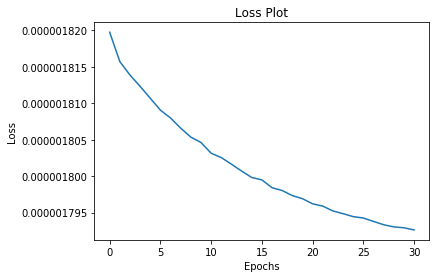

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    features = encoder(temp_input)

    dec_input = tf.expand_dims([START_TOKEN], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predictions = predictions.numpy()
        if np.sum(predictions[0]) < 0.1:
            break
            
        result.append(predictions[0])
        dec_input = tf.expand_dims(predictions, 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
import cv2
import os
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(15, 15))

    fname = os.path.basename(image)
    np.save(fname, attention_plot)

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (10, 10))
        temp_att = cv2.GaussianBlur(temp_att, (3, 3), 0)
        ax = fig.add_subplot(len_result, 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [0]:
save_att = ["/content/drive/My Drive/data/train/plots/train_27130.png",
"/content/drive/My Drive/data/train/plots/train_28784.png",
"/content/drive/My Drive/data/train/plots/train_15424.png",
"/content/drive/My Drive/data/train/plots/train_5712.png",
"/content/drive/My Drive/data/train/plots/train_27572.jpg",
"/content/drive/My Drive/data/train/plots/train_8139.jpg",
"/content/drive/My Drive/data/train/plots/train_23920.png",
"/content/drive/My Drive/data/train/plots/train_21669.jpg",
"/content/drive/My Drive/data/train/plots/train_1211.jpg",
"/content/drive/My Drive/data/train/plots/train_8799.png"]

/content/drive/My Drive/data/train/plots/train_27130.png


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


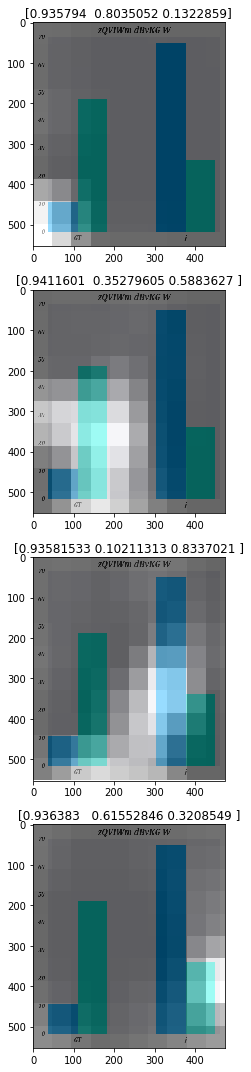

/content/drive/My Drive/data/train/plots/train_28784.png


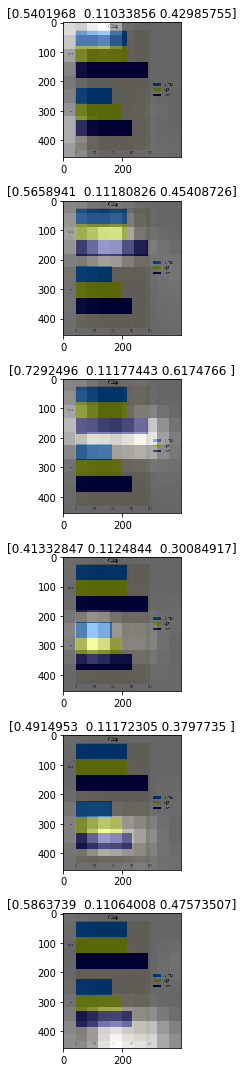

/content/drive/My Drive/data/train/plots/train_15424.png


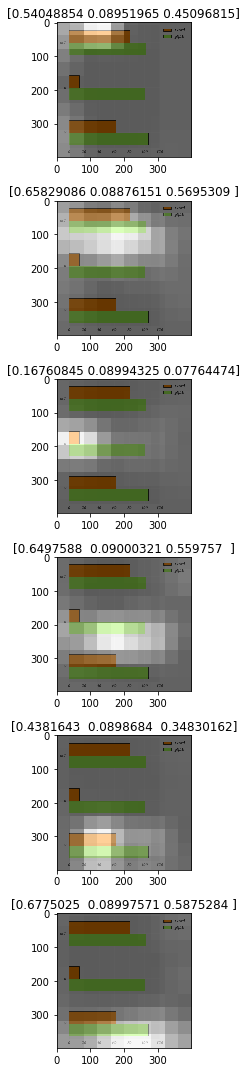

/content/drive/My Drive/data/train/plots/train_5712.png


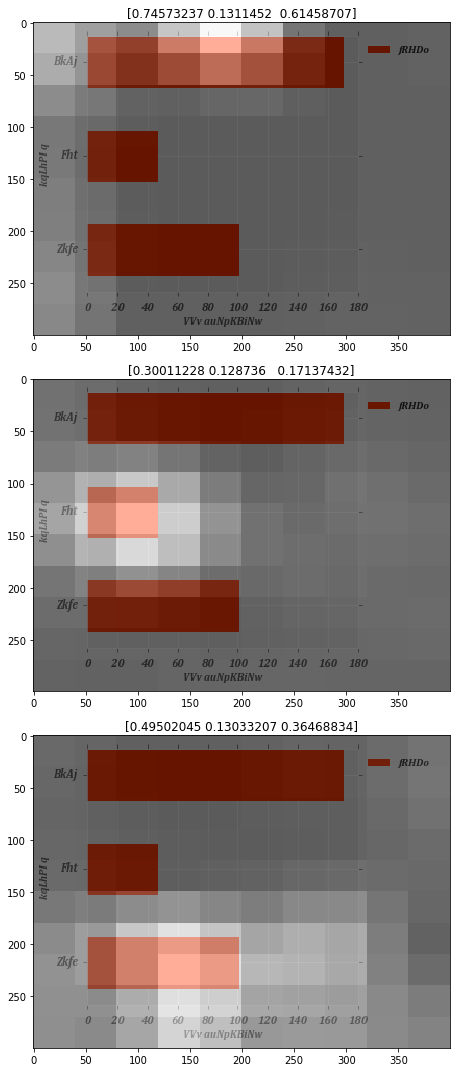

/content/drive/My Drive/data/train/plots/train_27572.jpg


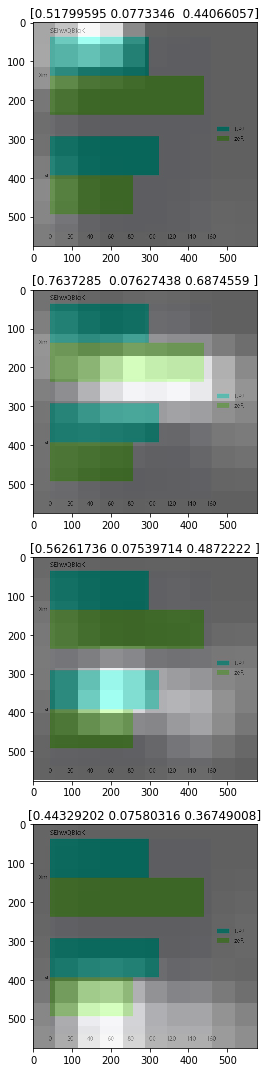

/content/drive/My Drive/data/train/plots/train_8139.jpg


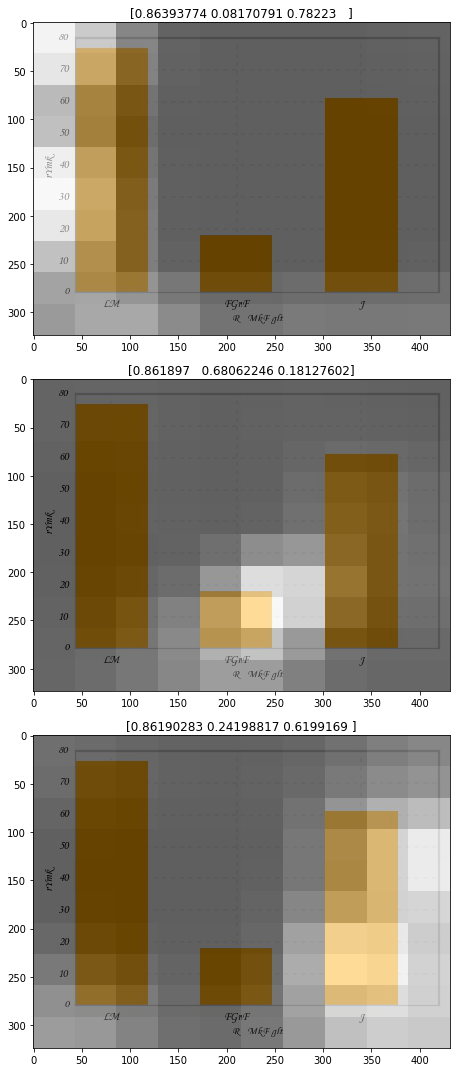

/content/drive/My Drive/data/train/plots/train_23920.png


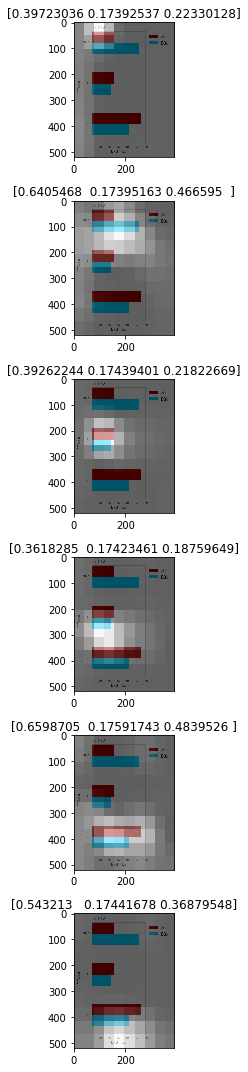

/content/drive/My Drive/data/train/plots/train_21669.jpg


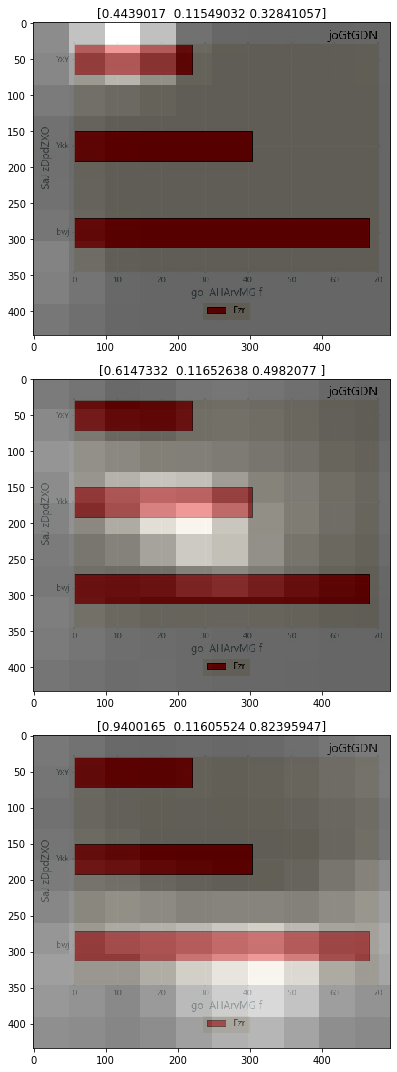

/content/drive/My Drive/data/train/plots/train_1211.jpg


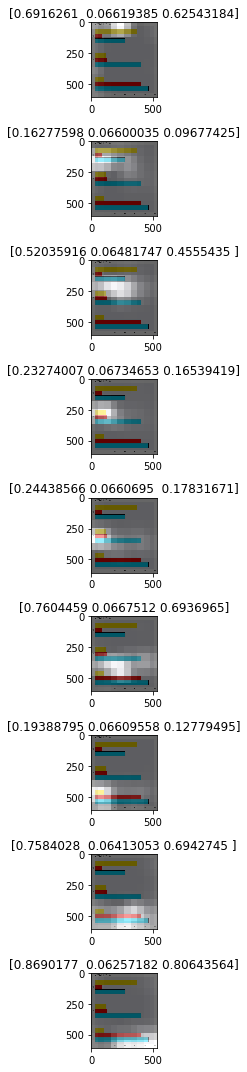

/content/drive/My Drive/data/train/plots/train_8799.png


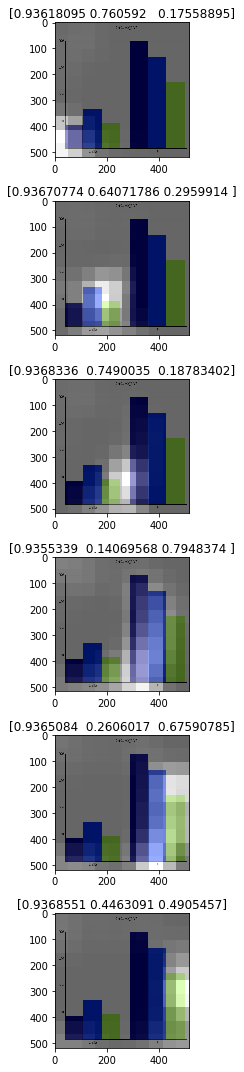

In [0]:
# extractions on the validation set
rid = np.random.randint(0, len(img_name_train))
image = img_name_train[rid]
#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
image = '/content/drive/My Drive/data/train/plots/train_1211.jpg'
for image in save_att:
    print(image)
    result, attention_plot = evaluate(image)

    #print ('Real Caption:', real_caption)
    #print ('Prediction Caption:', result)
    plot_attention(image, result, attention_plot)
# opening the image
#Image.open(img_name_train[rid])

In [0]:
! tar zcf npy.tar.gz ./*.npy